In [1]:
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient
        self.cl = 0.0 # lift coefficient
        self.cd = 0.0 # drag coefficient
        
def define_panels(x, y, N):    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    
    b = numpy.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):

    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2
        
def compute_lift_coefficient(panels):
    for panel in panels:
        panel.cl = - panel.cp * numpy.sin(panel.beta) * panel.length
        
def compute_drag_coefficient(panels):
    for panel in panels:
        panel.cd = panel.cp * numpy.cos(panel.beta) * panel.length

        
def calculate_Flow(x, y, u_inf = 1.0, alpha = 0.0):
    
    N = x.size - 1

    freestream = Freestream(u_inf, alpha)
    panels = define_panels(x, y, N)

    ASource = source_contribution_normal(panels)
    bVortex = vortex_contribution_normal(panels)

    A = build_singularity_matrix(ASource, bVortex)
    b = build_freestream_rhs(panels, freestream)

    strength = numpy.linalg.solve(A, b)

    for i, panel in enumerate(panels):
        panel.sigma = strength[i]

    gamma = strength[-1:]

    compute_tangential_velocity(panels, freestream, gamma, ASource, bVortex)
    compute_pressure_coefficient(panels, freestream)
    compute_lift_coefficient(panels)
    compute_drag_coefficient(panels)
       
    return panels, freestream, gamma

In [3]:
Foil50X, Foil50Y = numpy.loadtxt('NACA64-206.csv', dtype=float, delimiter=',', unpack=True)

In [4]:
# panels_u35_a4, freestream_u35_a4, gamma_u35_a4 = calculate_Flow(Foil50X, Foil50Y, u_inf = 3.55175, alpha = -8.0)

# c = abs(max(panel.xa for panel in panels_u35_a4) -
#         min(panel.xa for panel in panels_u35_a4))
# cl = (gamma_u35_a4 * sum(panel.length for panel in panels_u35_a4) /
#       (0.5 * freestream_u35_a4.u_inf * c))
# print('lift coefficient: CL = ', cl)

In [5]:
alphaList = numpy.linspace(-8.0, 6.0, 33)
print(alphaList)
cl = numpy.empty_like(alphaList)
cd = numpy.empty_like(alphaList)
u_inf = 3.55175 

for i in range(0, len(alphaList)):
    panels, freestream, gamma = calculate_Flow(Foil50X, Foil50Y, u_inf, alpha = alphaList[i])
    
    c = abs(max(panel.xa for panel in panels) - min(panel.xa for panel in panels))
    cl[i] = (gamma * sum(panel.length for panel in panels) / (0.5 * freestream.u_inf * c))
    cd[i] = (gamma * sum(panel.length for panel in panels) * alphaList[i]) / (0.5 * freestream.u_inf * c)

[-8.     -7.5625 -7.125  -6.6875 -6.25   -5.8125 -5.375  -4.9375 -4.5
 -4.0625 -3.625  -3.1875 -2.75   -2.3125 -1.875  -1.4375 -1.     -0.5625
 -0.125   0.3125  0.75    1.1875  1.625   2.0625  2.5     2.9375  3.375
  3.8125  4.25    4.6875  5.125   5.5625  6.    ]


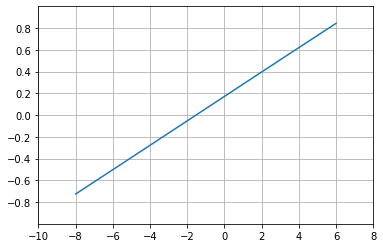

In [6]:
pyplot.plot(alphaList, cl)
pyplot.xlim(-10.0, 8.0)
pyplot.ylim(-1.0, 1.0)
pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
pyplot.yticks(numpy.arange(-0.8, 1.0, step=0.2))
pyplot.grid()

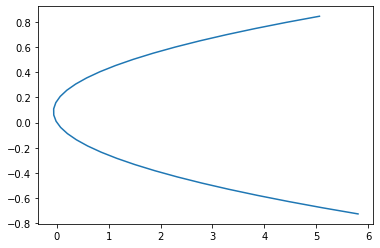

In [7]:
pyplot.plot(cd, cl)

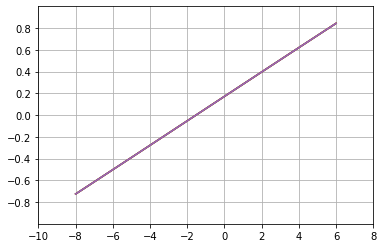

In [10]:
alphaList = numpy.linspace(-8.0, 6.0, 33)
u_infList = [3.55175, 7.1035, 14.207, 35.5175, 71.035]

cl = numpy.zeros((len(u_infList), len(alphaList)))
cd = numpy.zeros_like(cl)

for j in range(0, len(u_infList)):
    for i in range(0, len(alphaList)):
        panels, freestream, gamma = calculate_Flow(Foil50X, Foil50Y, u_inf = u_infList[j], alpha = alphaList[i])

        c = abs(max(panel.xa for panel in panels) - min(panel.xa for panel in panels))
        cl[j, i] = (gamma * sum(panel.length for panel in panels) / (0.5 * freestream.u_inf * c))
        cd[j, i] = (gamma * sum(panel.length for panel in panels) * alphaList[i]) / (0.5 * freestream.u_inf * c)
        
    pyplot.plot(alphaList, cl[j, :])
    pyplot.xlim(-10.0, 8.0)
    pyplot.ylim(-1.0, 1.0)
    pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
    pyplot.yticks(numpy.arange(-0.8, 1.0, step=0.2))
    pyplot.grid()

In [ ]:
pyplot.plot([panel.cl for panel in panels_u35_a4 if panel.loc == 'upper'], 
            [panel.cd for panel in panels_u35_a4 if panel.loc == 'upper'])

pyplot.plot([panel.cl for panel in panels_u35_a4 if panel.loc == 'lower'], 
            [panel.cd for panel in panels_u35_a4 if panel.loc == 'lower'])

In [ ]:
pyplot.plot([panel.xc for panel in panels_u35_a4 if panel.loc == 'upper'],
            [panel.cp for panel in panels_u35_a4 if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels_u35_a4 if panel.loc == 'lower'],
            [panel.cp for panel in panels_u35_a4 if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)

In [ ]:
# nx, ny = 50, 50 
# x_start, x_end = -0.5, 1.5
# y_start, y_end = -0.1, 0.1
# X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
#                       numpy.linspace(y_start, y_end, ny))

# u, v = get_velocity_field(panels_u35_a4, freestream, X, Y)

width = 20
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u_u35_a4, v_u35_a4,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels_u35_a4],
            [panel.yc for panel in panels_u35_a4],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.1, 0.1)
pyplot.title('Streamlines around a NACA 64-206 airfoil (AoA = ${}^o$)'.format(alpha),
             fontsize=16);

In [ ]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Foil50X, Foil50Y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);